In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv('btcusdt-5minute-1month.csv')

# data = pd.read_csv('btcusdt-15minute-7days.csv')

import matplotlib.pyplot as plt

btc_data = df.tail(288)
# btc_data = df.copy()
# Convert the timestamp column to a datetime object
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

# Set the timestamp as the index for easier plotting
btc_data.set_index('timestamp', inplace=True)



# Simulate a simple trading strategy with capital evolution (buy/sell on EMA crossovers)
initial_capital = 10000
capital = initial_capital
btc_data['Position'] = 0  # 1 for long, -1 for short, 0 for no position
btc_data['Capital'] = capital
btc_data['Trade'] = 0  # Track trades


C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\659888109.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])
C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\659888109.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['Position'] = 0  # 1 for long, -1 for short, 0 for no position
C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\659888109.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [16]:
import pandas as pd

# Definir os parâmetros
stop_loss_diff = 150
take_profit_diff = 150
initial_capital = 10000  # Capital inicial

# Calculate the Exponential Moving Averages (EMAs) for periods 21, 5, and 72
btc_data['EMA_21'] = btc_data['Close'].ewm(span=21, adjust=False).mean()
btc_data['EMA_5'] = btc_data['Close'].ewm(span=5, adjust=False).mean()

# Inicializar colunas no DataFrame
btc_data['Stop_Loss'] = None
btc_data['Take_Profit'] = None
btc_data['Position'] = 0
btc_data['Trade'] = 0
btc_data['Capital'] = initial_capital

# Variáveis de controle
position_active = False
position_type = None  # 'long' ou 'short'
entry_price = 0
btc_amount = 0
capital = initial_capital

for i in range(1, len(btc_data)):
    current_price = btc_data['Close'].iloc[i]
    prev_EMA_5 = btc_data['EMA_5'].iloc[i - 1]
    prev_EMA_21 = btc_data['EMA_21'].iloc[i - 1]
    current_EMA_5 = btc_data['EMA_5'].iloc[i]
    current_EMA_21 = btc_data['EMA_21'].iloc[i]
    
    # Verificar se a posição está ativa
    if position_active:
        if position_type == 'long':
            # Verificar stop loss para posição longa
            if current_price <= entry_price - stop_loss_diff:
                btc_data.at[btc_data.index[i], 'Stop_Loss'] = current_price
                capital = btc_amount * current_price
                btc_amount = 0
                position_active = False
                position_type = None
                btc_data.at[btc_data.index[i], 'Position'] = 0
            # Verificar take profit para posição longa
            elif current_price >= entry_price + take_profit_diff:
                btc_data.at[btc_data.index[i], 'Take_Profit'] = current_price
                capital = btc_amount * current_price
                btc_amount = 0
                position_active = False
                position_type = None
                btc_data.at[btc_data.index[i], 'Position'] = 0
        elif position_type == 'short':
            # Verificar stop loss para posição vendida
            if current_price >= entry_price + stop_loss_diff:
                btc_data.at[btc_data.index[i], 'Stop_Loss'] = current_price
                profit = btc_amount * current_price
                capital += profit
                btc_amount = 0
                position_active = False
                position_type = None
                btc_data.at[btc_data.index[i], 'Position'] = 0
            # Verificar take profit para posição vendida
            elif current_price <= entry_price - take_profit_diff:
                btc_data.at[btc_data.index[i], 'Take_Profit'] = current_price
                profit = btc_amount * current_price
                capital += profit
                btc_amount = 0
                position_active = False
                position_type = None
                btc_data.at[btc_data.index[i], 'Position'] = 0

    else:
        # Verificar cruzamento de EMAs para entrar na posição longa
        if prev_EMA_5 <= prev_EMA_21 and current_EMA_5 > current_EMA_21:
            entry_price = current_price
            btc_amount = capital / entry_price
            capital = 0
            position_active = True
            position_type = 'long'
            btc_data.at[btc_data.index[i], 'Position'] = 1
            btc_data.at[btc_data.index[i], 'Trade'] = 1  # Compra

        # Verificar cruzamento de EMAs para entrar na posição vendida (short)
        elif prev_EMA_5 >= prev_EMA_21 and current_EMA_5 < current_EMA_21:
            entry_price = current_price
            btc_amount = - (capital / entry_price)  # btc_amount negativo para posição vendida
            capital += abs(btc_amount) * entry_price  # Recebe capital da venda a descoberto
            position_active = True
            position_type = 'short'
            btc_data.at[btc_data.index[i], 'Position'] = -1
            btc_data.at[btc_data.index[i], 'Trade'] = -1  # Venda

    # Atualizar o capital ao longo do tempo
    if position_active:
        if position_type == 'long':
            total_capital = btc_amount * current_price
        elif position_type == 'short':
            total_capital = capital + btc_amount * current_price
        btc_data.at[btc_data.index[i], 'Capital'] = total_capital
    else:
        btc_data.at[btc_data.index[i], 'Capital'] = capital

# Exibir as colunas relevantes para inspeção
btc_data[['Close', 'EMA_5', 'EMA_21', 'RSI', 'Position', 'Trade', 'Capital', 'Stop_Loss', 'Take_Profit']].head()


import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Preparar os dados de sinais
long_entries = btc_data[(btc_data['Trade'] == 1) & (btc_data['Position'] == 1)]
long_exits = btc_data[(btc_data['Trade'] == -1) & (btc_data['Position'] == 0) & (btc_data['Stop_Loss'].notnull() | btc_data['Take_Profit'].notnull())]

short_entries = btc_data[(btc_data['Trade'] == -1) & (btc_data['Position'] == -1)]
short_exits = btc_data[(btc_data['Trade'] == 1) & (btc_data['Position'] == 0) & (btc_data['Stop_Loss'].notnull() | btc_data['Take_Profit'].notnull())]

# Iniciar a figura e os subplots
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar o preço do BTC e os EMAs
ax.plot(btc_data.index, btc_data['Close'], label='Preço BTC', color='blue', linewidth=1.5)
ax.plot(btc_data.index, btc_data['EMA_5'], label='EMA 5', color='red', linewidth=1)
ax.plot(btc_data.index, btc_data['EMA_21'], label='EMA 21', color='green', linewidth=1)

# Plotar sinais de entrada e saída de posições longas
ax.scatter(long_entries.index, long_entries['Close'], marker='^', color='lime', label='Entrada Longa', s=100)
ax.scatter(long_exits.index, long_exits['Close'], marker='v', color='darkgreen', label='Saída Longa', s=100)

# Plotar sinais de entrada e saída de posições vendidas (short)
ax.scatter(short_entries.index, short_entries['Close'], marker='v', color='darkred', label='Entrada Vendida', s=100)
ax.scatter(short_exits.index, short_exits['Close'], marker='^', color='pink', label='Saída Vendida', s=100)

# Plotar stop loss e take profit
stop_loss_signals = btc_data.dropna(subset=['Stop_Loss'])
take_profit_signals = btc_data.dropna(subset=['Take_Profit'])

ax.scatter(stop_loss_signals.index, stop_loss_signals['Stop_Loss'], marker='x', color='red', label='Stop Loss', s=100)
ax.scatter(take_profit_signals.index, take_profit_signals['Take_Profit'], marker='x', color='green', label='Take Profit', s=100)

# Configurar o formato das datas no eixo x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)

# Adicionar títulos e legendas
ax.set_title('Preço do BTC com EMAs e Sinais de Trade')
ax.set_xlabel('Data')
ax.set_ylabel('Preço (USD)')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Plotar a evolução do capital
plt.figure(figsize=(14, 5))
plt.plot(btc_data.index, btc_data['Capital'], label='Evolução do Capital', color='purple', linewidth=2)
plt.title('Evolução do Capital ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Capital (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\3263347429.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['EMA_21'] = btc_data['Close'].ewm(span=21, adjust=False).mean()
C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\3263347429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['EMA_5'] = btc_data['Close'].ewm(span=5, adjust=False).mean()
C:\Users\Pichau\AppData\Local\Temp\ipykernel_2536\3263347429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,Close,EMA_5,EMA_21,RSI,Position,Trade,Capital,Stop_Loss,Take_Profit
timestamp,,,,,,,,,
2024-09-20 00:50:00,62858.46,62858.460000,62858.460000,NaN,0,0,10000.000000,None,None
2024-09-20 00:55:00,62756.40,62824.440000,62849.181818,NaN,-1,-1,10000.000000,None,None
2024-09-20 01:00:00,62716.00,62788.293333,62837.074380,NaN,0,0,10006.437590,None,None
2024-09-20 01:05:00,62666.44,62747.675556,62821.562164,NaN,0,0,10014.334793,None,None
2024-09-20 01:10:00,62709.30,62734.883704,62811.356513,NaN,0,0,10007.505211,None,None


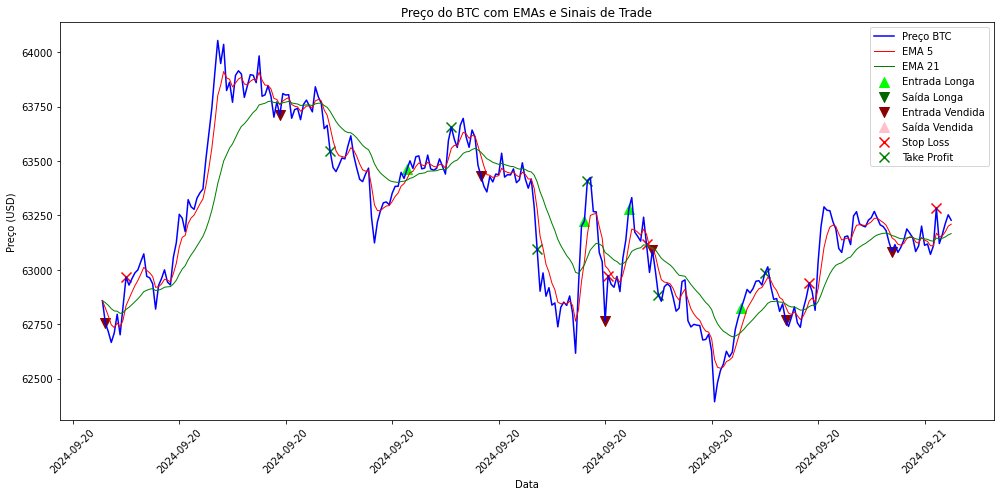

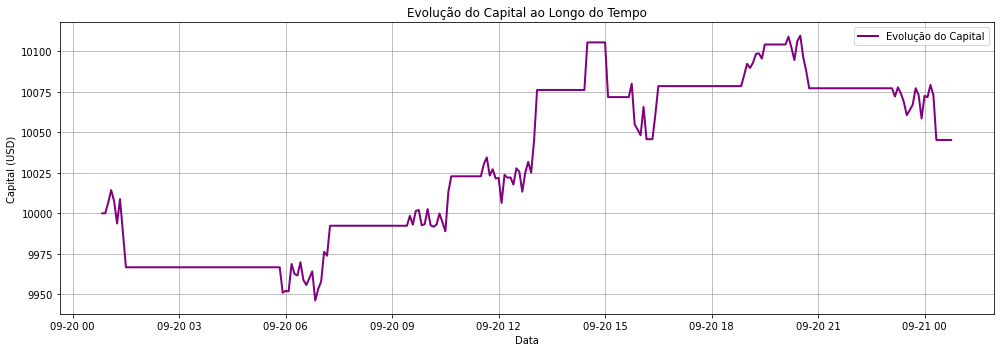

In [21]:
import pandas as pd
import numpy as np
from binance.client import Client
import matplotlib.pyplot as plt
import time
from datetime import datetime
from dotenv import load_dotenv
import os
import requests
from matplotlib.animation import FuncAnimation
import threading



load_dotenv()

# Carregar as variáveis de ambiente
chat_id = os.getenv('CHAT_ID')
token = os.getenv('TOKEN')
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

# Inicializar o cliente da Binance
client = Client(api_key, api_secret)

In [54]:
# klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_15MINUTE, '7 days ago UTC')
# data = pd.DataFrame(klines, columns=[
#     'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
#     'Close_time', 'Quote_asset_volume', 'Number_of_trades', 
#     'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
# ])
# data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
# data.set_index('timestamp', inplace=True)
# print(f"Dados carregados: {data.shape[0]} linhas")

Dados carregados: 672 linhas


In [55]:
# data.to_csv('btcusdt-15minute-7days.csv')

In [8]:
def send_telegram_message(message):
    """Envia uma mensagem para o Telegram."""
    try:
        print(f"Enviando mensagem para o Telegram: {message}")
        url_base = f'https://api.telegram.org/bot{token}/sendMessage'
        params = {'chat_id': chat_id, 'text': message}
        response = requests.get(url_base, params=params)
        response.raise_for_status()
        print("Mensagem enviada com sucesso.")
        return response.json()['result']['message_id']
    except requests.RequestException as e:
        print(f"Erro ao enviar mensagem para o Telegram: {e}")
        return None

In [9]:
def calculate_indicators(data, ema_short_period, ema_long_period, rsi_period):
    """Calcula as EMAs, VWAP e sinais de compra/venda."""
    print(f"Calculando indicadores com EMA Curta: {ema_short_period}, EMA Longa: {ema_long_period}, RSI Período: {rsi_period}")
    
    # EMAs e VWAP
    data['ema_short'] = data['Close'].ewm(span=ema_short_period, adjust=False).mean()
    data['ema_long'] = data['Close'].ewm(span=ema_long_period, adjust=False).mean()
    data['vwap'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Cálculo do RSI
    delta = data['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Sinais baseados no RSI
    data['rsi_signal'] = np.where(data['rsi'] > 70, -1.0, np.where(data['rsi'] < 30, 1.0, 0.0))
    
    # Sinais baseados em EMAs e VWAP
    data['signal'] = np.where(
        (data['ema_short'] > data['ema_long']) & (data['Close'] > data['vwap']), 1.0,
        np.where((data['ema_short'] < data['ema_long']) & (data['Close'] < data['vwap']), -1.0, 0.0)
    )
    
    # Combinar sinais: se houver sinal de RSI, usá-lo; senão, usar o sinal baseado em EMAs
    data['signal'] = np.where(data['rsi_signal'] != 0, data['rsi_signal'], data['signal'])
    
    # Determinar posições
    data['positions'] = data['signal'].diff()
    
    print(f"Indicadores calculados para {len(data)} linhas de dados.")
    return data

In [10]:
def backtest(data, initial_capital):
    """Executa o backtest com base nos sinais de compra/venda."""
    positions = data['signal'].fillna(0.0)
    cash_flow = -positions.diff().multiply(data['Close'])
    portfolio = pd.DataFrame({
        'positions': positions.multiply(data['Close']),
        'cash': initial_capital + cash_flow.cumsum()
    })
    portfolio['total'] = portfolio['positions'] + portfolio['cash']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

def get_historical_data(symbol, interval, period):
    """Carrega dados históricos do Binance."""
    print(f"Carregando dados históricos para {symbol} com intervalo {interval} e período {period}.")
    klines = client.get_historical_klines(symbol, interval, period)
    data = pd.DataFrame(klines, columns=[
        'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
        'Close_time', 'Quote_asset_volume', 'Number_of_trades', 
        'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    print(f"Dados carregados: {data.shape[0]} linhas")
    return data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

def backtest(data, initial_capital):
    """Executa o backtest com base nos sinais de compra/venda."""
    positions = data['signal'].copy()
    cash_flow = -positions.diff().multiply(data['Close'])
    portfolio = pd.DataFrame({
        'positions': positions.multiply(data['Close']),
        'cash': initial_capital + cash_flow.cumsum()
    })
    portfolio['total'] = portfolio['positions'] + portfolio['cash']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

def get_historical_data(symbol, interval, period):
    """Carrega dados históricos do Binance."""
    print(f"Carregando dados históricos para {symbol} com intervalo {interval} e período {period}.")
    klines = client.get_historical_klines(symbol, interval, period)
    data = pd.DataFrame(klines, columns=[
        'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
        'Close_time', 'Quote_asset_volume', 'Number_of_trades', 
        'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    print(f"Dados carregados: {data.shape[0]} linhas")
    return data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
import matplotlib.pyplot as plt
import time
from datetime import datetime
from dotenv import load_dotenv
import os
import requests
from matplotlib.animation import FuncAnimation
import threading

load_dotenv()

# Carregar as variáveis de ambiente
chat_id = os.getenv('CHAT_ID')
token = os.getenv('TOKEN')
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

# Inicializar o cliente da Binance
client = Client(api_key, api_secret)

def send_telegram_message(message):
    """Envia uma mensagem para o Telegram."""
    try:
        print(f"Enviando mensagem para o Telegram: {message}")
        url_base = f'https://api.telegram.org/bot{token}/sendMessage'
        params = {'chat_id': chat_id, 'text': message}
        response = requests.get(url_base, params=params)
        response.raise_for_status()
        print("Mensagem enviada com sucesso.")
        return response.json()['result']['message_id']
    except requests.RequestException as e:
        print(f"Erro ao enviar mensagem para o Telegram: {e}")
        return None

def find_support_resistance(data, window=20):
    """Encontra os níveis de suporte e resistência."""
    data['resistance_level'] = data['High'].rolling(window=window, min_periods=1).max().shift(1)
    data['support_level'] = data['Low'].rolling(window=window, min_periods=1).min().shift(1)
    return data

def process_pending_signals(data):
    """Processa os sinais pendentes para gerar posições quando o preço ultrapassa os níveis de suporte/resistência."""
    position = 0.0
    pending_buy = False
    pending_sell = False
    buy_resistance_level = None
    sell_support_level = None
    positions = []

    for idx, row in data.iterrows():
        if position == 0.0:
            # Sem posição atual
            if row['pending_signal'] == 1.0 and not pending_buy:
                # Gerar sinal de compra pendente
                pending_buy = True
                buy_resistance_level = row['resistance_level']
            elif row['pending_signal'] == -1.0 and not pending_sell:
                # Gerar sinal de venda pendente
                pending_sell = True
                sell_support_level = row['support_level']

            if pending_buy:
                # Verificar se o preço ultrapassa o nível de resistência
                if row['High'] > buy_resistance_level:
                    position = 1.0
                    positions.append(position)
                    pending_buy = False
                    buy_resistance_level = None
                else:
                    positions.append(position)
            elif pending_sell:
                # Verificar se o preço cai abaixo do nível de suporte
                if row['Low'] < sell_support_level:
                    position = -1.0
                    positions.append(position)
                    pending_sell = False
                    sell_support_level = None
                else:
                    positions.append(position)
            else:
                positions.append(position)
        else:
            # Posição atual mantida
            if position == 1.0:
                # Posição comprada
                if row['pending_signal'] == -1.0 and not pending_sell:
                    pending_sell = True
                    sell_support_level = row['support_level']

                if pending_sell:
                    if row['Low'] < sell_support_level:
                        position = 0.0  # Sair da posição comprada
                        positions.append(position)
                        pending_sell = False
                        sell_support_level = None
                    else:
                        positions.append(position)
                else:
                    positions.append(position)
            elif position == -1.0:
                # Posição vendida
                if row['pending_signal'] == 1.0 and not pending_buy:
                    pending_buy = True
                    buy_resistance_level = row['resistance_level']

                if pending_buy:
                    if row['High'] > buy_resistance_level:
                        position = 0.0  # Sair da posição vendida
                        positions.append(position)
                        pending_buy = False
                        buy_resistance_level = None
                    else:
                        positions.append(position)
                else:
                    positions.append(position)
            else:
                positions.append(position)

    data['positions'] = positions
    data['position_change'] = data['positions'].diff()
    return data

def calculate_indicators(data, ema_short_period, ema_long_period, rsi_period):
    """Calcula as EMAs, VWAP e sinais de compra/venda."""
    print(f"Calculando indicadores com EMA Curta: {ema_short_period}, EMA Longa: {ema_long_period}, RSI Período: {rsi_period}")
    
    # EMAs e VWAP
    data['ema_short'] = data['Close'].ewm(span=ema_short_period, adjust=False).mean()
    data['ema_long'] = data['Close'].ewm(span=ema_long_period, adjust=False).mean()
    data['vwap'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Cálculo do RSI
    delta = data['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    data['rsi'] = 100 - (100 / (1 + rs))
    
    # Sinais baseados no RSI
    data['rsi_signal'] = np.where(data['rsi'] > 70, -1.0, np.where(data['rsi'] < 30, 1.0, 0.0))
    
    # Sinais baseados em EMAs e VWAP
    data['signal'] = np.where(
        (data['ema_short'] > data['ema_long']) & (data['Close'] > data['vwap']), 1.0,
        np.where((data['ema_short'] < data['ema_long']) & (data['Close'] < data['vwap']), -1.0, 0.0)
    )
    
    # Combinar sinais: se houver sinal de RSI, usá-lo; senão, usar o sinal baseado em EMAs
    data['signal'] = np.where(data['rsi_signal'] != 0, data['rsi_signal'], data['signal'])
    
    # Criar coluna de sinais pendentes
    data['pending_signal'] = data['signal']
    
    # Encontrar níveis de suporte e resistência
    data = find_support_resistance(data, window=20)
    
    # Processar sinais pendentes para gerar posições
    data = process_pending_signals(data)
    
    print(f"Indicadores calculados para {len(data)} linhas de dados.")
    return data

def backtest(data, initial_capital):
    """Executa o backtest com base nos sinais de compra/venda."""
    positions = data['positions'].fillna(0.0)
    cash_flow = -positions.diff().multiply(data['Close'])
    portfolio = pd.DataFrame({
        'positions': positions.multiply(data['Close']),
        'cash': initial_capital + cash_flow.cumsum()
    })
    portfolio['total'] = portfolio['positions'] + portfolio['cash']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

def get_historical_data(symbol, interval, period):
    """Carrega dados históricos do Binance."""
    print(f"Carregando dados históricos para {symbol} com intervalo {interval} e período {period}.")
    klines = client.get_historical_klines(symbol, interval, period)
    data = pd.DataFrame(klines, columns=[
        'timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 
        'Close_time', 'Quote_asset_volume', 'Number_of_trades', 
        'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    print(f"Dados carregados: {data.shape[0]} linhas")
    return data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# Parâmetros iniciais
initial_capital = 10000.0
# Otimização dos parâmetros EMA
best_total = 0
best_ema_short_period = 3
best_ema_long_period = 23

# Carregar os dados históricos do BTC/USD com intervalo de 5 minutos
data = get_historical_data('BTCUSDT', Client.KLINE_INTERVAL_5MINUTE, '7 days ago UTC')

# Testar diferentes combinações de períodos das EMAs
best_rsi_period = 14  # Defina o período do RSI
for ema_short_period in range(3, 15):
    for ema_long_period in range(15, 50):
        data_with_indicators = calculate_indicators(data.copy(), ema_short_period, ema_long_period, best_rsi_period)
        portfolio = backtest(data_with_indicators, initial_capital)
        final_total = portfolio['total'].iloc[-1]
        
        if final_total > best_total:
            best_total = final_total
            best_ema_short_period = ema_short_period
            best_ema_long_period = ema_long_period
            print(f"Novo melhor total: {best_total} com EMA Curta: {best_ema_short_period}, EMA Longa: {best_ema_long_period} e RSI Período: {best_rsi_period}")

print(f"\nMelhor total: {best_total} com EMA Curta: {best_ema_short_period}, EMA Longa: {best_ema_long_period}, e RSI Período: {best_rsi_period}")

# Calcular indicadores com os melhores parâmetros, incluindo o RSI
data = calculate_indicators(data, best_ema_short_period, best_ema_long_period, best_rsi_period)

if data.empty:
    print("Erro: Nenhum dado foi carregado.")
else:
    print(f"Dados carregados: {data.shape[0]} linhas")

# Executar backtest com os melhores parâmetros
portfolio = backtest(data, initial_capital)

# Inicializar a visualização
plt.ion()  # Habilitar modo interativo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plotar as linhas iniciais
line_price, = ax1.plot([], [], label='Preço BTC/USD', color='blue', lw=2)
line_ema_short, = ax1.plot([], [], label=f'EMA Curta ({best_ema_short_period})', color='green', lw=2)
line_ema_long, = ax1.plot([], [], label=f'EMA Longa ({best_ema_long_period})', color='red', lw=2)
line_vwap, = ax1.plot([], [], label='VWAP', color='purple', lw=2)
lin_rsi, = ax1.plot([], [], label='RSI', color='orange', lw=2)
line_buy_signals, = ax1.plot([], [], '^', markersize=10, color='m', label='Sinal de Compra')
line_sell_signals, = ax1.plot([], [], 'v', markersize=10, color='k', label='Sinal de Venda')

line_capital, = ax2.plot([], [], label='Evolução do Capital', color='purple', lw=2)

ax1.legend()
ax1.grid()
ax2.legend()
ax2.grid()

fig.autofmt_xdate()

# Variáveis para armazenar o último sinal enviado
last_buy_signal_time = None
last_sell_signal_time = None

def update_graph(frame):
    """Atualiza o gráfico com novos dados."""
    global data, portfolio, last_buy_signal_time, last_sell_signal_time

    try:
        print("Atualizando o gráfico...")
        data = get_historical_data('BTCUSDT', Client.KLINE_INTERVAL_5MINUTE, '7 days ago UTC')
        data = calculate_indicators(data, best_ema_short_period, best_ema_long_period, best_rsi_period)
        portfolio = backtest(data, initial_capital)
        
        data = data.tail(100)
        portfolio = portfolio.tail(100)
        
        # Atualizar gráficos
        line_price.set_data(data.index, data['Close'])
        line_ema_short.set_data(data.index, data['ema_short'])
        line_ema_long.set_data(data.index, data['ema_long'])
        line_vwap.set_data(data.index, data['vwap'])
        lin_rsi.set_data(data.index, data['rsi'])

        buy_signals = data.loc[data['position_change'] == 1.0]
        sell_signals = data.loc[data['position_change'] == -1.0]

        line_buy_signals.set_data(buy_signals.index, buy_signals['Close'])
        line_sell_signals.set_data(sell_signals.index, sell_signals['Close'])

        line_capital.set_data(portfolio.index, portfolio['total'])

        # Verificar e enviar sinal de compra
        if not buy_signals.empty and buy_signals.index[-1] != last_buy_signal_time:
            last_buy_signal_time = buy_signals.index[-1]
            buy_price = buy_signals['Close'].iloc[-1]
            print(f"\nSinal de Compra em {last_buy_signal_time}: {buy_price}")
            send_telegram_message(f"Sinal de Compra em {last_buy_signal_time}: {buy_price}")

        # Verificar e enviar sinal de venda
        if not sell_signals.empty and sell_signals.index[-1] != last_sell_signal_time:
            last_sell_signal_time = sell_signals.index[-1]
            sell_price = sell_signals['Close'].iloc[-1]
            print(f"\nSinal de Venda em {last_sell_signal_time}: {sell_price}")
            send_telegram_message(f"Sinal de Venda em {last_sell_signal_time}: {sell_price}")

        # Ajustar limites dos eixos
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()

        fig.canvas.draw()

    except Exception as e:
        print(f"Erro ao atualizar o gráfico: {e}")
        # Opcionalmente, enviar uma mensagem de erro para o Telegram
        send_telegram_message(f"Erro ao atualizar o gráfico: {e}")
        time.sleep(10)  # Espera 10 segundos antes de tentar novamente

# Configurar animação
ani = FuncAnimation(fig, update_graph, interval=60000, cache_frame_data=False)  # Atualiza a cada 1 minuto (60000ms)

plt.ioff()  # Desabilitar modo interativo
plt.show()


Carregando dados históricos para BTCUSDT com intervalo 5m e período 7 days ago UTC.
Dados carregados: 2016 linhas
Calculando indicadores com EMA Curta: 3, EMA Longa: 15, RSI Período: 14
Indicadores calculados para 2016 linhas de dados.
Novo melhor total: 2905.1599999999817 com EMA Curta: 3, EMA Longa: 15 e RSI Período: 14
Calculando indicadores com EMA Curta: 3, EMA Longa: 16, RSI Período: 14
Indicadores calculados para 2016 linhas de dados.
Novo melhor total: 5873.599999999984 com EMA Curta: 3, EMA Longa: 16 e RSI Período: 14
Calculando indicadores com EMA Curta: 3, EMA Longa: 17, RSI Período: 14
Indicadores calculados para 2016 linhas de dados.
Calculando indicadores com EMA Curta: 3, EMA Longa: 18, RSI Período: 14
Indicadores calculados para 2016 linhas de dados.
Novo melhor total: 6407.439999999995 com EMA Curta: 3, EMA Longa: 18 e RSI Período: 14
Calculando indicadores com EMA Curta: 3, EMA Longa: 19, RSI Período: 14
Indicadores calculados para 2016 linhas de dados.
Calculando ind

KeyboardInterrupt: 

In [13]:
def update_graph(frame):
    """Atualiza o gráfico com novos dados."""
    global data, portfolio, last_buy_signal_time, last_sell_signal_time

    try:
        print("Atualizando o gráfico...")
        
        # Recarregar os dados mais recentes da Binance
        data = get_historical_data('BTCUSDT', Client.KLINE_INTERVAL_5MINUTE, '7 days ago UTC')
        data = calculate_indicators_with_patterns(data, best_ema_short_period, best_ema_long_period, best_rsi_period)
        portfolio = backtest(data, initial_capital)
        
        # Verificar os dados carregados
        if data.empty:
            print("Erro: Nenhum dado foi carregado.")
            return
        else:
            print(f"Dados carregados: {data.shape[0]} linhas")

        data = data.tail(100)  # Apenas os últimos 100 pontos para melhor visualização
        portfolio = portfolio.tail(100)  # Apenas os últimos 100 pontos para melhor visualização
        
        # Aplicar média móvel no capital para suavização
        portfolio['total_smooth'] = portfolio['total'].rolling(window=10).mean()  # Média móvel de 10 períodos
        
        # Atualizar gráficos com dados completos
        line_price.set_data(data.index, data['Close'])
        line_ema_short.set_data(data.index, data['ema_short'])
        line_ema_long.set_data(data.index, data['ema_long'])
        line_vwap.set_data(data.index, data['vwap'])

        buy_signals = data.loc[data['positions'] == 1.0]
        sell_signals = data.loc[data['positions'] == -1.0]

        line_buy_signals.set_data(buy_signals.index, buy_signals['Close'])
        line_sell_signals.set_data(sell_signals.index, sell_signals['Close'])

        line_rsi.set_data(data.index, data['rsi'])

        # Atualizar o gráfico de capital com a média móvel
        line_capital.set_data(portfolio.index, portfolio['total_smooth'])

        # Ajustar limites dos eixos
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()
        ax3.relim()
        ax3.autoscale_view()

        # Redesenhar a tela
        fig.canvas.draw()
        plt.pause(0.1)  # Pausar brevemente para garantir que o gráfico seja atualizado corretamente

    except Exception as e:
        # print traceback
        print(f"Erro ao atualizar o gráfico: {e}")

# Configurar animação
ani = FuncAnimation(fig, update_graph, interval=60000, cache_frame_data=False)

plt.show()


In [14]:
plt.show()